In [23]:

import numpy as np
# import scipy as scp
# import pylab as pyl
# import pywt
# import pandas as pd
# import holoviews as hv
# import param
# import panel as pn
#from panel.pane import LaTeX
# hv.extension('bokeh')
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from scipy.sparse import diags
import scipy as scp
from scipy.sparse import hstack
from scipy.sparse import vstack
from scipy.sparse import csr_matrix

from PIL import Image
import scipy.io as sio
import argparse
# from sklearn.metrics import jaccard_score
from mpl_toolkits.mplot3d import Axes3D

## Loading original image and noisy image

In [24]:
def PSNR(I,Iref):
    temp=I.ravel()
    tempref=Iref.ravel()
    NbP=I.size
    EQM=np.sum((temp-tempref)**2)/NbP
    b=np.max(np.abs(tempref))**2
    return 10*np.log10(b/EQM)

In [7]:
# img1 = square(50)
img1 = Image.open('test_image.png').convert('L')
# img1 = Image.open('../images/[R=12][size=50].png')
# img1 = Image.open('images/ellipse.png')
# img1 = img1.resize((100, 100), Image.ANTIALIAS)
img1 = np.array(img1).astype('float32')/255.

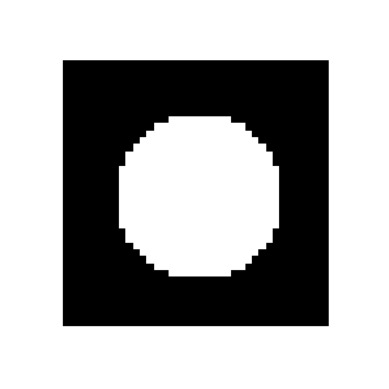

In [8]:
# plt.figure(figsize=(6,6))
plt.imshow(img1,'gray')
plt.axis('off')
plt.show()

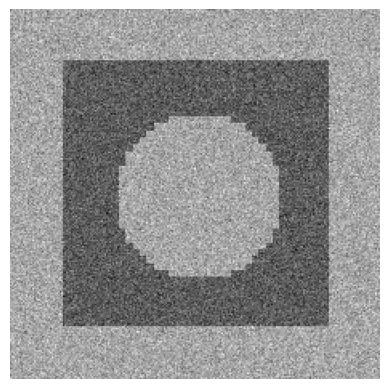

[[0.41228305 0.90350628 1.08852871 ... 0.69773592 1.13366829 1.28619439]
 [0.7127883  1.35199006 0.8278012  ... 0.86327762 0.91165016 1.02075122]
 [1.23734157 1.22608997 0.88579413 ... 1.12813258 0.8387539  0.90413538]
 ...
 [0.25226098 1.13509021 0.87672337 ... 0.80458623 0.83104598 0.74422854]
 [0.84138079 1.14780197 1.09412492 ... 1.06053884 1.15620891 0.57855732]
 [1.59313364 1.19231942 0.68716468 ... 1.29461354 1.01329061 1.14097026]]


In [9]:
std= 0.3
# plt.figure(figsize=(5,5))
img1_noised = img1 + std*np.random.normal(0,1,np.shape(img1))
#img1_noised = (img1_noised - np.min(img1_noised)) / (np.max(img1_noised) - np.min(img1_noised))

# img1_noised = Image.open('noisy_images/[none-blurring][Gaussian-0.3][[R=12][size=50]].png')
# img1_noised = Image.open('noisy_images/')
# img1_noised = np.array(img1_noised).astype('float32')/255.
plt.imshow(img1_noised,'gray')
plt.axis('off')
plt.show()
print(img1_noised)

The objective of this exercice is to obtain a piecewise constant estimate $\hat{x}$ which is the closest to the original $\bar{x}$ from data $y$. A solution consists in minimizing the following objective function :

$$\hat{x}_{\lambda}=\underset{x\in \mathbb{R}^N}{\text{argmin}} f(x) + g(Lx)$$


$$\hat{x}_{\lambda}=\underset{x\in \mathbb{R}^N}{\text{argmin}} \frac{1}{2}\Vert x-y \Vert^2_2 + \lambda\Vert \nabla x\Vert_1$$


where $L = [H; V]$ where $Hx = \big(x_{i,1}-x_{i,0},\dots,x_{i,N-1}-x_{i,N-2}\big)_{1\leq i\leq N}$ and $Vx = \Big(x_{1,i}-x_{0,i},\dots,x_{N-1,i}-x_{N-2,i}\big)_{1\leq i\leq N})$ for $1\leq i\leq N-1$, $y\in \mathbb{R}^N$ and $\lambda>0$ and $H \in \mathbb{R}^{(N-1)\times N}$


$\textbf{Question 4:}$

In [10]:
def GradientHor(x):
    y=x-np.roll(x,1,axis=1)
    y[:,0]=0
    return y
def GradientVer(x):
    y=x-np.roll(x,1,axis=0)
    y[0,:]=0
    return y
def DivHor(x):
    N=len(x[0])
    y=x-np.roll(x,-1,axis=1)
    y[:,0]=-x[:,1]
    y[:,N-1]=x[:,N-1]
    return y
def DivVer(x):
    N=len(x)
    y=x-np.roll(x,-1,axis=0)
    y[0,:]=-x[1,:]
    y[N-1,:]=x[N-1,:]
    return y
def Gradient(x):
    y=[]
    y.append(GradientHor(x))
    y.append(GradientVer(x))
    return np.asarray(y)
def Div(y):
    x=DivHor(y[0])+DivVer(y[1])
    return x

In [11]:
def ProjGradBouleInf(g,l):
    gh=g[0]
    gv=g[1]
    temp=g
    p0=gh-(gh-l)*(gh>l)-(gh+l)*(gh<-l)
    p1=gv-(gv-l)*(gv>l)-(gv+l)*(gv<-l)
    temp[0]=p0
    temp[1]=p1
    return temp

$\textbf{Question 5:}$

Let $\tau \in ]0,+\infty]$, $\sigma\in]0,+\infty]$ and $\sigma\tau\Vert L\Vert^2<1$


Chambolle-Pock algorithm:
    
$$
(\forall n \in \mathbb{N}) \quad\left\{\begin{array}{l}
x_{n+1}=\operatorname{prox}_{\tau f}\left(x_{n} - \tau L^{*} v_{n}\right) \\
y_{n}=2 x_{n+1}-x_{n} \\
v_{n+1}=\operatorname{prox}_{\sigma g^{*}}\left(v_{n}+\sigma L y_{n}\right)
\end{array}\right.
$$

$\textbf{Computation of prox_L2}$

$$
\mathrm{prox}_{\frac{\tau}{2}\Vert A \cdot -z\Vert_2^2}(x) = \arg\min_y \frac{\tau}{2}\Vert A y -z\Vert_2^2 +  \frac{1}{2}\Vert  y -x\Vert_2^2
$$

by Fermat rule:
$ \tau A^\top (A y - z ) + y - x = 0$
leading to

$$
\mathrm{prox}_{\frac{\tau}{2}\Vert A \cdot -z\Vert_2^2}(x) = (\tau A^\top A + \textrm{I})^{-1}(\tau A^\top z + x)
$$


In the case of inpainting matrix :

$$
\mathrm{prox}_{\frac{\tau}{2}\Vert A \cdot -z\Vert_2^2}(x) = \begin{cases}
(\tau A^\top z + x)_i/(\tau + 1) &\quad \mbox{if $i$ is associated to a location of a  known value}\\
(\tau A^\top z + x)_i &\quad \mbox{otherwise} 
\end{cases}
$$



In [12]:
def Prox_normL2(x,tau,z):
    return (x+tau*z)/(1+tau)

In [13]:
def ChambollePockDenoisingTV(y,lamb,tau,sigma,Niter):
    
    # Initialization of the primal solution
    x_n = y
    # Initialization dual solution
    v_n = Gradient(x_n)
    
    table_energy = 1e10*np.ones(Niter)
    table_PSNR = 1e10*np.ones(Niter)
    
    for k in range(0,Niter):
        x_n = Prox_normL2(x_n-tau*Div(v_n),tau,y)
        y_n = 2*x_n-x_n
        v_n = ProjGradBouleInf(v_n+sigma*Gradient(y_n),lamb)
#         table_energy[k] = 0.5*np.sum((DivHor(v_n))**2)+lamb*np.sum(np.abs(GradientHor(y+DivHor(v_n))))
        table_energy[k] = 0.5*np.sum((y-x_n)**2)+lamb*np.sum(np.abs(Gradient(x_n)))
#         table_PSNR[k] = PSNR(y+Gradient(v_n),img1)
#         table_PSNR[k] = PSNR(x_n,img1)
#     x = y+DivHor(u_n)
    x = x_n
    return x,table_energy,table_PSNR

In [14]:
print(img1_noised.shape)
x_Chambolle_Pock,table_energy_Chambolle_Pock,table_PSNR_Chambolle_Pock = ChambollePockDenoisingTV(img1_noised,lamb=0.7,tau=0.1,sigma=0.01,Niter=5000)


(231, 231)


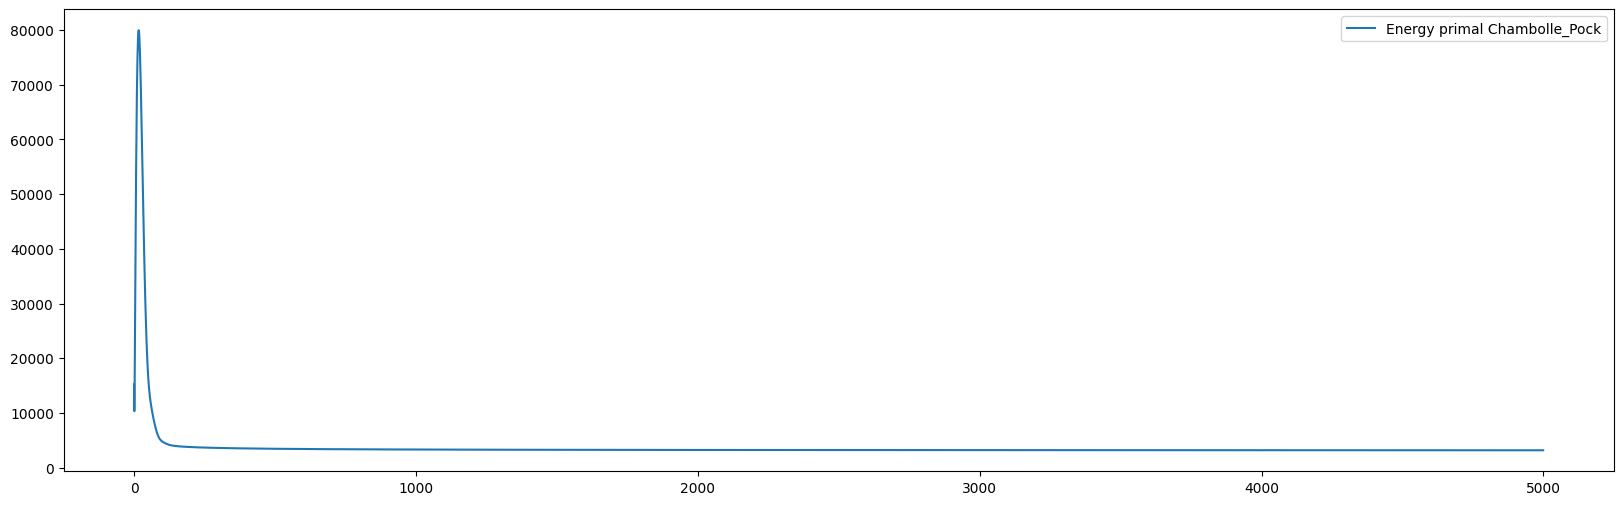

In [15]:
plt.figure(figsize=(20,6))
plt.plot(table_energy_Chambolle_Pock[:],label='Energy primal Chambolle_Pock')
#plt.plot(table_energy_primal_FB[:],label='Energy primal_FB')
plt.legend()
plt.show()

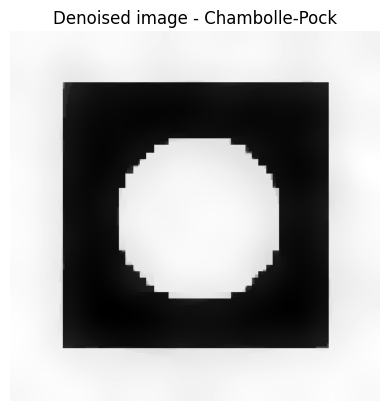

In [16]:
plt.imshow(x_Chambolle_Pock,'gray')
plt.title('Denoised image - Chambolle-Pock')
plt.axis('off')
plt.show()

## New implementation

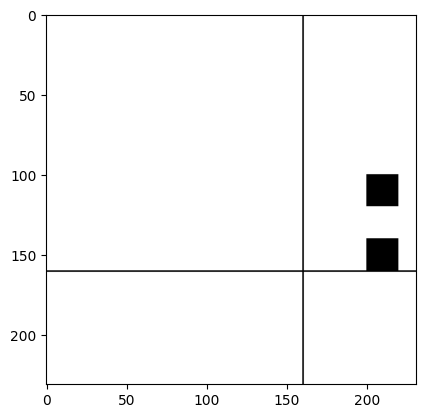

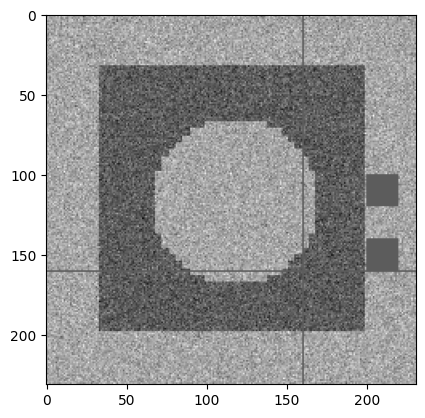

In [20]:
#create data with missing values from image above
mask = np.ones(img1_noised.shape);
mask[100:120,200:220] = 0;
mask[140:160,240:260] = 0;
mask[100:120,240:260] = 0;
mask[140:160,200:220] = 0;
mask[100:400,300:400] = 0;
mask[170:150,270:350] = 0;
mask[:, 160] = 0;
mask[160,:] = 0;
img1_masked = img1_noised*mask;
plt.figure();
plt.imshow(mask, 'gray');
plt.figure();
plt.imshow(img1_masked, 'gray');
img1_mask = mask;

In [21]:

def Prox_normL2_Ainpainting(x, tau, z, mask):
    # z should be the zeros interpolating image
    
    # The mask is useful -> how do I associate each z_i with index of x...
    # Use the mask like this.
    return (x + mask * tau * z) / (np.ones(x.shape) + mask * tau);
    # tmp = (x+tau*z)
    # output = tmp/(1+tau)
    # output(ind_missing_value) = tmp(ind_missing_value)
    #
    #return ...


def prox_L1(x, tau):
    return np.sign(x)*np.maximum(np.abs(x)-tau,0)


def ProjGradBouleInf(x,l,tau):
    temp = x - tau*prox_L1(x/tau, l/tau)
    return temp
    
# def ProjGradBouleInfSplit(g,l0,l1):
#     gh=g[0]
#     gv=g[1]
#     temp=g
#     p0=gh-(gh-l0)*(gh>l0)-(gh+l0)*(gh<-l0)
#     p1=gv-(gv-l1)*(gv>l1)-(gv+l1)*(gv<-l1)
#     temp[0]=p0
#     temp[1]=p1
#     return temp
    
def ChambollePockDenoisingTVinpainting(y,mask,lamb,tau,sigma,Niter):
    
    # Initialization of the primal solution
    x_n = y
    # Initialization dual solution
    v_n = Gradient(x_n)
    
    table_energy = 1e10*np.ones(Niter)
    table_PSNR = 1e10*np.ones(Niter)
    
    for k in range(0,Niter):
        x_n = Prox_normL2_Ainpainting(x_n-tau*Div(v_n),tau,y, mask)
        y_n = 2*x_n-x_n
        v_n = ProjGradBouleInf(v_n+sigma*Gradient(y_n), lamb, sigma);
#         table_energy[k] = 0.5*np.sum((DivHor(v_n))**2)+lamb*np.sum(np.abs(GradientHor(y+DivHor(v_n))))
        grad = Gradient(x_n);
#         grad[0] = lamb[0] * grad[0];
#         grad[1] = lamb[1] * grad[1];
        table_energy[k] = 0.5*np.sum(mask*(y-x_n)**2)+lamb*np.sum(np.abs(grad));
#         table_PSNR[k] = PSNR(y+Gradient(v_n),img1)
#         table_PSNR[k] = PSNR(x_n,img1)
#     x = y+DivHor(u_n)
    x = x_n
    return x,table_energy,table_PSNR

In [22]:
print(img1_noised.shape);
sigma = 0.1
tau = 0.99/(1 + 4*sigma);
x_Chambolle_Pock,table_energy_Chambolle_Pock,table_PSNR_Chambolle_Pock = ChambollePockDenoisingTVinpainting(img1_masked, img1_mask, lamb=1.0,tau=tau,sigma=sigma,Niter=5000)

(231, 231)


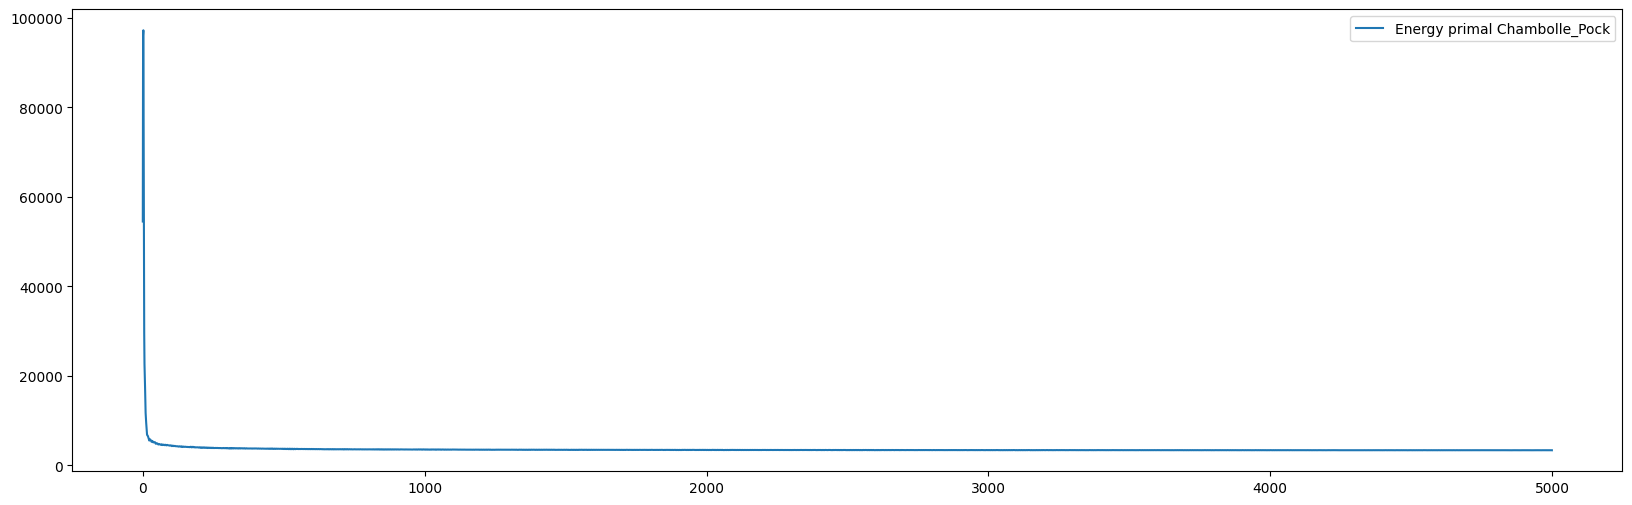

In [23]:
plt.figure(figsize=(20,6))
plt.plot(table_energy_Chambolle_Pock[:],label='Energy primal Chambolle_Pock')
#plt.plot(table_energy_primal_FB[:],label='Energy primal_FB')
plt.legend()
plt.show()

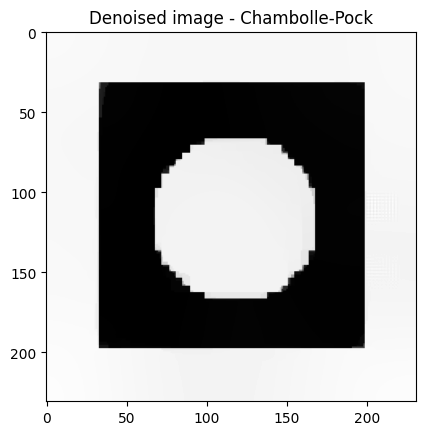

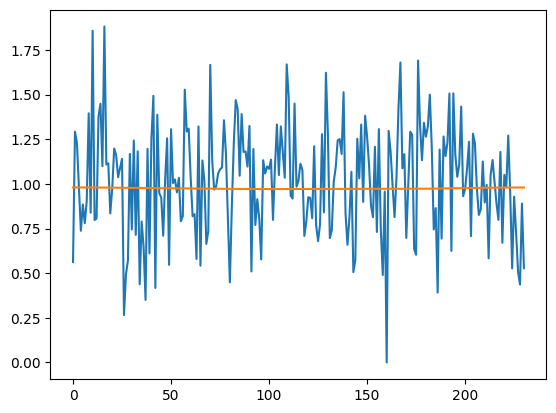

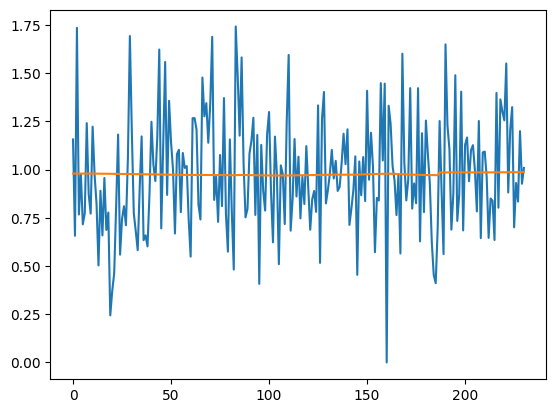

In [24]:
plt.imshow(x_Chambolle_Pock,'gray')
plt.title('Denoised image - Chambolle-Pock')
# plt.axis('off')
plt.show()

plt.figure();
plt.plot(img1_masked[25,:]);
plt.plot(x_Chambolle_Pock[25,:]);

plt.figure();
plt.plot(img1_masked[:,30]);
plt.plot(x_Chambolle_Pock[:,30]);

In [40]:
# Feedback from Barbara (TODO: Data Processing)
# --> DGO [1-22] (must not be any holes (really?))
# --> 21,22 missing, to 23,24 --> perhaps reformat?

# Average if values between two tiles are not too different (what metric should I use?)
# Keep largest values while Barbara rectifies her code (if two are VERY different)

# Barbara suggests focusing on the MNDWI only. This avoids the double-readings...


# I've found the problem... Actually, when I've extracted the data, I've used 2 different indices to extract water surfaces and I've let both of them in the csv file (but I forgot to mention it...). The indices:
# NDWI = it is based on Green and Nir bands)
# MNDWI = it is based on Green and Swir bands).
# This information is available in the column "Indicator" (and also under "source").
# Since we have progressed a bit with the understanding of such indices, I think it is better if you use values from MNDWI (and the associated area and braiding index). In general, NDWI underestimates a bit water surfaces and MNDWI is better but sometimes it overestimates.
# So, by identifying the index and working on one at a time you will solve most of the problems (maybe except for DGO 21 where multiple tiles are present?). I suggest to focus on MNDWI values only.
# I hope this helps.
# Best


# River Data

In [25]:
%run Khalid_Data_Processing.ipynb

Exception: File `'Khalid_Data_Processing.ipynb'` not found.

Are there NaNs: False


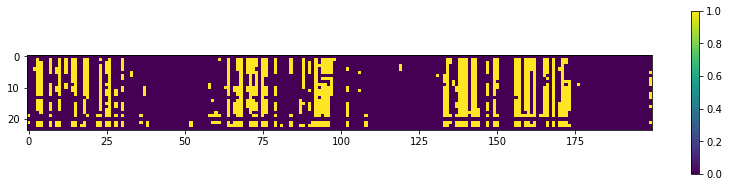

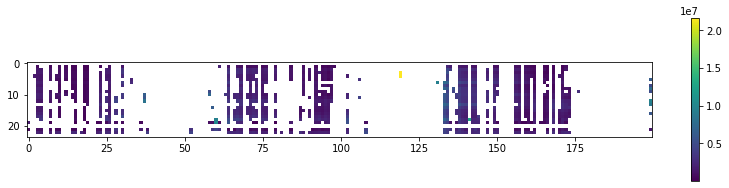

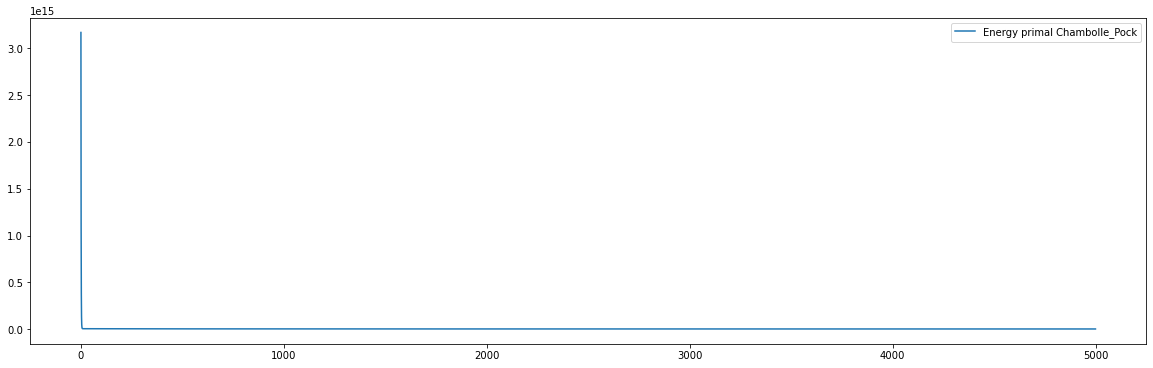

In [42]:
xt_data = np.copy(Z);
mask = np.ones(xt_data.shape);
mask[np.isnan(xt_data)] = 0;

plt.figure(figsize=(14, 3));
plt.imshow(mask);
plt.colorbar();

plt.figure(figsize=(14, 3));
plt.imshow(xt_data);
plt.colorbar();
xt_data[np.isnan(xt_data)] = 0;
print("Are there NaNs:",np.any(np.isnan(xt_data)));

# Let's try 1 dimension
xt_cp, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask, lamb=1000.0,tau=tau,sigma=sigma,Niter=5000)

plt.figure(figsize=(20,6))
plt.plot(_[0][:],label='Energy primal Chambolle_Pock')
#plt.plot(table_energy_primal_FB[:],label='Energy primal_FB')
plt.legend()
plt.show()


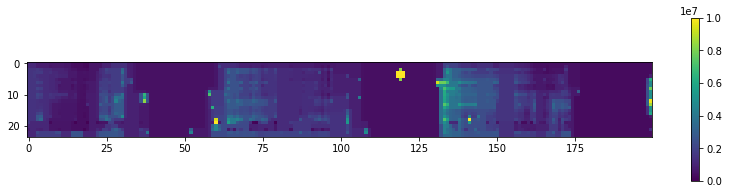

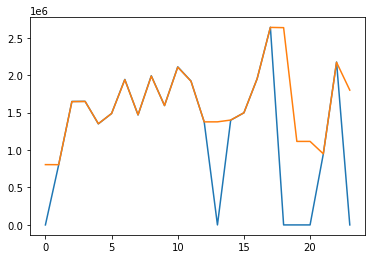

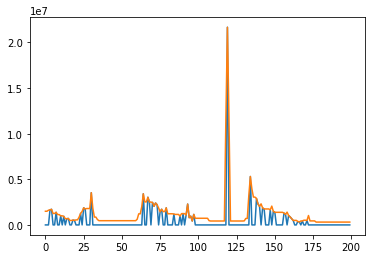

In [43]:

plt.figure(figsize=(14, 3));
plt.imshow(xt_cp,vmin=0, vmax=1e7,);
plt.colorbar();

plt.figure();
plt.plot(xt_data[:, 3]);
plt.plot(xt_cp[:, 3]);
plt.show();

plt.figure();
plt.plot(xt_data[3, :]);
plt.plot(xt_cp[3, :]);
plt.show();

# print(xt_cp)

### New test NP

Are there NaNs: False


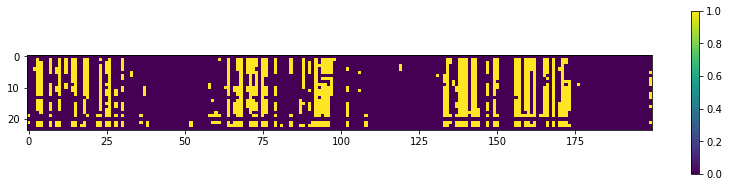

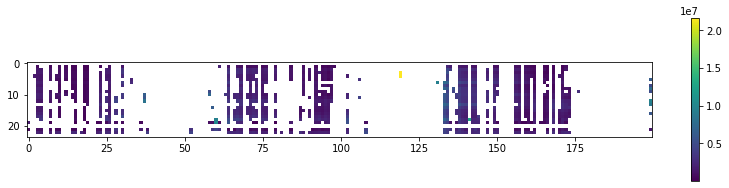

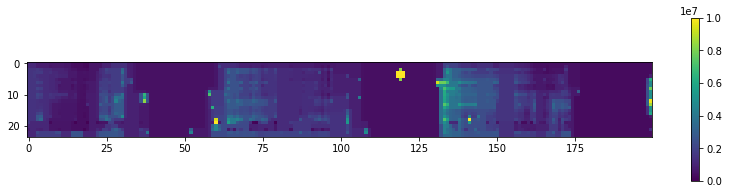

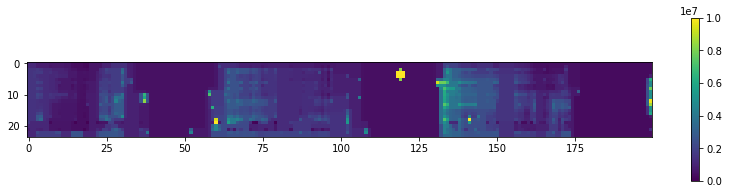

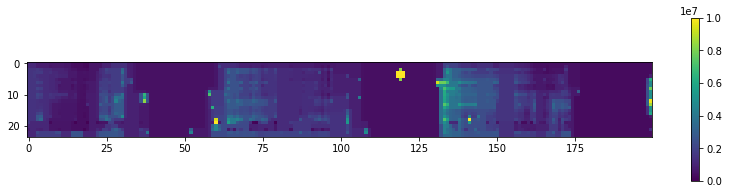

In [44]:
xt_data = np.copy(Z);
mask = np.ones(xt_data.shape);
mask[np.isnan(xt_data)] = 0;

plt.figure(figsize=(14, 3));
plt.imshow(mask);
plt.colorbar();

plt.figure(figsize=(14, 3));
plt.imshow(xt_data);
plt.colorbar();
xt_data[np.isnan(xt_data)] = 0;
print("Are there NaNs:",np.any(np.isnan(xt_data)));

# Let's try 1 dimension
xt_cp1, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask, lamb=1.0,tau=tau,sigma=sigma,Niter=5000)


plt.figure(figsize=(14, 3));
plt.imshow(xt_cp,vmin=0, vmax=1e7,);
plt.colorbar();


# Let's try 1 dimension
xt_cp2, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask, lamb=100000.0,tau=tau,sigma=sigma,Niter=5000)


plt.figure(figsize=(14, 3));
plt.imshow(xt_cp,vmin=0, vmax=1e7,);
plt.colorbar();

# Let's try 1 dimension
xt_cp3, *_ = ChambollePockDenoisingTVinpainting(xt_data, mask, lamb=1000000.0,tau=tau,sigma=sigma,Niter=5000)


plt.figure(figsize=(14, 3));
plt.imshow(xt_cp,vmin=0, vmax=1e7,);
plt.colorbar();





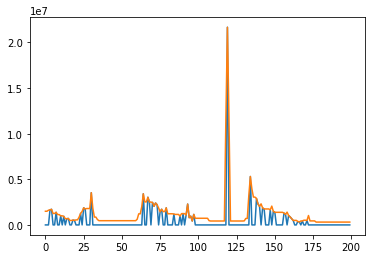

In [45]:
plt.figure()
plt.plot(xt_data[3,:])
plt.plot(xt_cp[3,:])